# EDA & Feature Engineering

The first part of this notebook focuses on feature engineering before moving onto EDA

Feature Engineering steps include:

1) Removing the obviously unecessary columns i.e. Playlist Name, Version, Game Type etc..

2) Grouping all the columns, which contain: 'player.awards', 'brMissionStats', 'playerStats.objective'into single variables. This was done for two reasons: 
    
    - it streamlines/simplifies the analysis
    
    - It creates a single variable with significnce vs many light (on data columns)

3) Removing all the Team Placement rows which include a null

4) Regrouping game mode into 4 labels: quad/trio/duo/solo

5) Creating per min varibales to eliminate the presence of time played from variables. i.e. distance travelled per min is indpendent of time played, which is correlated to distance travelled (i.e. the longer you play the longer the distance you travel)

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
import json
import time
import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 10000

In [101]:
df = pd.read_csv('emperor_df.csv', index_col = 0)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (51) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [102]:
df.head(5)

utcStartSeconds  utcEndSeconds      map       mode              matchID  \
0       1609797099     1609798716  mp_don3  br_brduos  6562602456312274390   
1       1609797099     1609798716  mp_don3  br_brduos  6562602456312274390   
2       1609797099     1609798716  mp_don3  br_brduos  6562602456312274390   
3       1609797099     1609798716  mp_don3  br_brduos  6562602456312274390   
4       1609797099     1609798716  mp_don3  br_brduos  6562602456312274390   

   duration  playlistName  version gameType  playerCount  teamCount  \
0   1617000           NaN        1       wz          150         78   
1   1617000           NaN        1       wz          150         78   
2   1617000           NaN        1       wz          150         78   
3   1617000           NaN        1       wz          150         78   
4   1617000           NaN        1       wz          150         78   

   rankedTeams   draw  privateMatch  playerStats.kills  playerStats.medalXp  \
0          NaN  False         False                2.0                  0.0   
1          NaN  False         False                3.0                 30.0   
2          NaN  False         False                3.0                 25.0   
3          NaN  False         False                2.0                 45.0   
4          NaN  False         False                1.0                 10.0   

   playerStats.objectiveLastStandKill  playerStats.matchXp  \
0                                 2.0               7930.0   
1                                 2.0               6206.0   
2                                 1.0               6915.0   
3                                 1.0               5607.0   
4                                 NaN               2317.0   

   playerStats.scoreXp  playerStats.wallBangs  playerStats.score  \
0               1675.0                    0.0             1675.0   
1               4000.0                    0.0             4000.0   
2               3300.0                    0.0             2900.0   
3               2825.0                    0.0             1025.0   
4                500.0                    0.0              500.0   

   playerStats.totalXp  playerStats.headshots  playerStats.assists  \
0               9610.0                    0.0                  0.0   
1              10293.0                    1.0                  0.0   
2              10293.0                    0.0                  0.0   
3               8477.0                    1.0                  0.0   
4               2827.0                    0.0                  0.0   

   playerStats.challengeXp  playerStats.rank  playerStats.scorePerMinute  \
0                      0.0              54.0                  122.411693   
1                      0.0              54.0                  386.473430   
2                      0.0              54.0                  195.725534   
3                      0.0              54.0                  103.187919   
4                      0.0              54.0                   90.909091   

   playerStats.distanceTraveled  playerStats.teamSurvivalTime  \
0                     403287.88                      754512.0   
1                     341555.66                      583056.0   
2                     376851.97                      666528.0   
3                     252540.73                      528144.0   
4                     278487.44                      275040.0   

   playerStats.deaths  playerStats.objectiveMunitionsBoxTeammateUsed  \
0                 2.0                                            1.0   
1                 2.0                                            NaN   
2                 2.0                                            1.0   
3                 2.0                                            NaN   
4                 2.0                                            NaN   

   playerStats.kdRatio  playerStats.objectiveBrDownEnemyCircle1  \
0                  1.0                                      2.0   
1             

In [103]:
df.shape

(148854, 179)

In [104]:
df1 = df.copy()

In [105]:
# Removing all the columns with no values/same values/or obvious irrelevance to the exercise
df1.drop(columns = ['playlistName','version','gameType','rankedTeams', 'draw','privateMatch', 'playerStats.wallBangs', 
          'playerStats.challengeXp', 'playerStats.bonusXp','playerStats.nearmisses', 'playerStats.miscXp', 'utcStartSeconds', 'utcEndSeconds', 'matchID',
                     'player.team', 'player.rank', 'player.uno', 'attachment_4', 'attachment_5', 'sec_attachment_3','sec_attachment_4', 'sec_attachment_5', 
                     'perk_2', 'perk_3', 'duration',
                     'extraperk_1', 'extraperk_2', 'extraperk_3', 'killstreak_1', 'killstreak_2', 'killstreak_3'], axis =1, inplace = True)

In [106]:
# These columns are dropped from the 'objective' category because I deemed them to be too telling of Team Placement.
# I.e. the higher ranked a team the more team wiped objectives it is likely to have completed
df1.drop(columns = ['playerStats.objectiveTeamWiped','playerStats.objectiveBrDownEnemyCircle1','playerStats.objectiveBrDownEnemyCircle2',
                   'playerStats.objectiveBrDownEnemyCircle3','playerStats.objectiveBrDownEnemyCircle4',
                    'playerStats.objectiveBrDownEnemyCircle5','playerStats.objectiveBrDownEnemyCircle6'], inplace = True)

In [107]:
# This function groups all the respective columns into single columns.

def drop(dfs):
    awards = []
    columns_xp = []
    columns_wepxp = []
    objective = []
    count = []
    for column in dfs:
        if 'player.awards' in column:
            awards.append(column)
            
        elif 'brMissionStats' and 'xp' in column:
            columns_xp.append(column)   
            
        elif 'brMissionStats' and 'weaponXp' in column:
            columns_wepxp.append(column)     
            
        elif 'playerStats.objective' in column: 
            objective.append(column)
            
        elif 'brMission' and 'count' in column:
            count.append(column)
            
    
    dfs['total_awardXP'] = dfs[awards].sum(axis = 1)   
#     dfs['brMissionStats_totalXP'] = dfs[columns_xp].sum(axis = 1)  
#     dfs['brMissionStats_totalWEPXP'] = dfs[columns_wepxp].sum(axis = 1)
    dfs['objective_completed'] = dfs[objective].sum(axis = 1)
    dfs.drop(awards+ columns_xp + columns_wepxp + objective + count, axis=1, inplace = True)
   

In [108]:
drop(df1)

In [109]:
df1.head(5)

map       mode  playerCount  teamCount  playerStats.kills  \
0  mp_don3  br_brduos          150         78                2.0   
1  mp_don3  br_brduos          150         78                3.0   
2  mp_don3  br_brduos          150         78                3.0   
3  mp_don3  br_brduos          150         78                2.0   
4  mp_don3  br_brduos          150         78                1.0   

   playerStats.medalXp  playerStats.matchXp  playerStats.scoreXp  \
0                  0.0               7930.0               1675.0   
1                 30.0               6206.0               4000.0   
2                 25.0               6915.0               3300.0   
3                 45.0               5607.0               2825.0   
4                 10.0               2317.0                500.0   

   playerStats.score  playerStats.totalXp  playerStats.headshots  \
0             1675.0               9610.0                    0.0   
1             4000.0              10293.0                    1.0   
2             2900.0              10293.0                    0.0   
3             1025.0               8477.0                    1.0   
4              500.0               2827.0                    0.0   

   playerStats.assists  playerStats.rank  playerStats.scorePerMinute  \
0                  0.0              54.0                  122.411693   
1                  0.0              54.0                  386.473430   
2                  0.0              54.0                  195.725534   
3                  0.0              54.0                  103.187919   
4                  0.0              54.0                   90.909091   

   playerStats.distanceTraveled  playerStats.teamSurvivalTime  \
0                     403287.88                      754512.0   
1                     341555.66                      583056.0   
2                     376851.97                      666528.0   
3                     252540.73                      528144.0   
4                     278487.44                      275040.0   

   playerStats.deaths  playerStats.kdRatio  playerStats.gulagDeaths  \
0                 2.0                  1.0                      1.0   
1                 2.0                  1.5                      0.0   
2                 2.0                  1.5                      0.0   
3                 2.0                  1.0                      1.0   
4                 2.0                  0.5                      0.0   

   playerStats.timePlayed  playerStats.executions  playerStats.gulagKills  \
0                   821.0                     0.0                     0.0   
1                   621.0                     0.0                     1.0   
2                   889.0                     0.0                     1.0   
3                   596.0                     0.0                     0.0   
4                   330.0                     0.0                     1.0   

   playerStats.percentTimeMoving  playerStats.longestStreak  \
0                      90.787710                        2.0   
1                      93.264244                        2.0   
2                      77.015650                        2.0   
3                      91.522156                        2.0   
4                      93.750000                        1.0   

   playerStats.teamPlacement  playerStats.damageDone  playerStats.damageTaken  \
0                       23.0                  1104.0                    697.0   
1                       34.0                   830.0                    362.0   
2                       30.0                   783.0                    301.0   
3                       38.0                   672.0                    434.0   
4                       62.0                   582.0                    285.0   

   player.username player.clantag  player.brMissionStats.missionsComplete  \
0           _Luis_      ^3SpoWo^7                                     0.0   
1        Pinkohero            BAS             

In [110]:
df1.to_csv('df1.csv')

In [239]:
df2 = df1.copy()

In [240]:
df2.describe(include = 'all')

map        mode    playerCount      teamCount  playerStats.kills  \
count    148854      148854  148854.000000  148854.000000      148854.000000   
unique        4          19            NaN            NaN                NaN   
top     mp_don3  br_brquads            NaN            NaN                NaN   
freq     144392       65617            NaN            NaN                NaN   
mean        NaN         NaN     150.503030      47.850451           1.987941   
std         NaN         NaN      12.757504      12.463371           2.605149   
min         NaN         NaN      46.000000       0.000000           0.000000   
25%         NaN         NaN     150.000000      39.000000           0.000000   
50%         NaN         NaN     151.000000      49.000000           1.000000   
75%         NaN         NaN     152.000000      51.000000           3.000000   
max         NaN         NaN     204.000000     150.000000          58.000000   

        playerStats.medalXp  playerStats.matchXp  playerStats.scoreXp  \
count         148487.000000        148487.000000        148487.000000   
unique                  NaN                  NaN                  NaN   
top                     NaN                  NaN                  NaN   
freq                    NaN                  NaN                  NaN   
mean              59.456080          6242.980106          3357.446396   
std              164.212786          3958.870772          3875.344743   
min                0.000000             0.000000             0.000000   
25%                0.000000          2814.000000           625.000000   
50%               10.000000          5958.000000          2000.000000   
75%               35.000000          9486.000000          4820.000000   
max             8920.000000         17639.000000         48665.000000   

        playerStats.score  playerStats.totalXp  playerStats.headshots  \
count       148487.000000        148487.000000          148487.000000   
unique                NaN                  NaN                    NaN   
top                   NaN                  NaN                    NaN   
freq                  NaN                  NaN                    NaN   
mean          2353.150788         10003.855651               0.419175   
std           2701.342474          7752.766552               0.906301   
min              0.000000             0.000000               0.000000   
25%            425.000000          3737.000000               0.000000   
50%           1325.000000          8488.000000               0.000000   
75%           3500.000000         14745.000000               1.000000   
max          31200.000000         88203.000000              49.000000   

        playerStats.assists  playerStats.rank  playerStats.scorePerMinute  \
count         148854.000000     148487.000000               148487.000000   
unique                  NaN               NaN                         NaN   
top                     NaN               NaN                         NaN   
freq                    NaN               NaN                         NaN   
mean               0.095926         51.236580                  147.437398   
std                0.496751          9.611281                  127.861162   
min                0.000000          0.000000                    0.000000   
25%                0.000000         54.000000                   50.751880   
50%                0.000000         54.000000                  113.402062   
75%                0.000000         54.000000                  216.119829   
max               15.000000         54.000000                 1339.207048   

        playerStats.distanceTraveled  playerStats.teamSurvivalTime  \
count                   1.484870e+05                  1.439260e+05   
unique                           NaN                           NaN   
top                              NaN                           NaN   
freq                             NaN                           NaN   
mean                  

In [241]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148854 entries, 0 to 149
Data columns (total 44 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   map                                               148854 non-null  object 
 1   mode                                              148854 non-null  object 
 2   playerCount                                       148854 non-null  int64  
 3   teamCount                                         148854 non-null  int64  
 4   playerStats.kills                                 148854 non-null  float64
 5   playerStats.medalXp                               148487 non-null  float64
 6   playerStats.matchXp                               148487 non-null  float64
 7   playerStats.scoreXp                               148487 non-null  float64
 8   playerStats.score                                 148487 non-null  float64
 9   playerS

In [242]:
df1['mode'].value_counts()

br_brquads                   65617
br_brtrios                   55392
br_brduos                    10630
br_brthquad                   4000
br_25                         3154
br_dmz_plnbld                 2419
br_brbbquad                   2133
br_dmz_plndtrios              1759
br_89                         1062
br_brsolo                      746
br_brduostim_name2             602
br_dmz_bldmnyquad              308
br_br_real                     303
br_brtriostim_name2            299
br_kingslayer_kingsltrios      108
br_dmz_plunquad                100
br_dmz_76                       99
br_mini_miniroyale              77
br_rebirth_rbrthtrios           46
Name: mode, dtype: int64

In [243]:
df2['player.clantag'].value_counts()

TTV      609
420      197
WGGK     128
BLM      127
TURK     116
        ... 
FIFA       1
PECKA      1
KKTC       1
gtxs       1
KE3F       1
Name: player.clantag, Length: 52354, dtype: int64

From df2.info it can be observed that many categories have significant nulls and that others will need 
feature engineering:
   
       feature engineering:
      
      1) Game mode: there are 19 different game modes. Creating 4 distinct categories would help make the                 analyis more comparable
      
      2) Clantag and username both will be transformed into a binary format (username will focus on the presence           of the most common players Caedrius and morag)
      
      3) Due to the abundance of data all the nulls will be dropped

In [244]:
# All these game modes were dropped because they do not have any team placement values
df2.set_index('mode', inplace=True)
df2.drop(['br_dmz_76', 'br_dmz_plnbld', 'br_dmz_plndtrios', 'br_dmz_plndtrios', 'br_dmz_bldmnyquad', 
          'br_kingslayer_kingsltrios' , 'br_kingslayer_kingsltrios', 'br_dmz_plunquad','br_89' ], inplace = True)


In [245]:
# The remainding NAs are dropped
df2 = df2.dropna(axis=0, subset=['playerStats.medalXp', 'playerStats.teamPlacement'])

In [246]:
# The remainding game modes are grouped into 4 categories
df2.reset_index(inplace=True)

mode = []
for x in df2['mode']:
    if 'quad' in x:
        mode.append('quad')
    elif 'trio' in x:
        mode.append('trio')
    elif 'duo' in x:
        mode.append('duo')
    else:
        mode.append('solo') 
df2['mode'] = mode

In [247]:
# The username column is binarised with the two main usernames = 1. This was done just in case some 
# explantory meaning could be extraceted from having downloaded Caedrius's data
df2['player.username'] = [1 if x == 'Caedrius' else 1 if x == 'morag' else 0 for x in df2['player.username']]

In [248]:
# Since c.50% of the players had a clantag I chose to binarise that variable to see if having a clan 
# could impact victory
df2.update(df2[['player.clantag']].fillna('none'))
df2['player.clantag'] = [0 if x =='none' else 1 for x in df2['player.clantag']]

In [249]:
# The empty dictionaries are filled with nulls in to make data manipulation possible
df2['primary'] = df2['primary'].replace(['{}'],'none')
df2['secondary'] = df2['secondary'].replace(['{}'],'none')
df2['lethal'] = df2['lethal'].replace(['{}'],'none')
df2['tactical'] = df2['tactical'].replace(['{}'],'none')

In [250]:
df2.update(df2[['attachment_1', 'attachment_2', 'attachment_3',
                'sec_attachment_1','sec_attachment_2', 'perk_1']].fillna('none'))

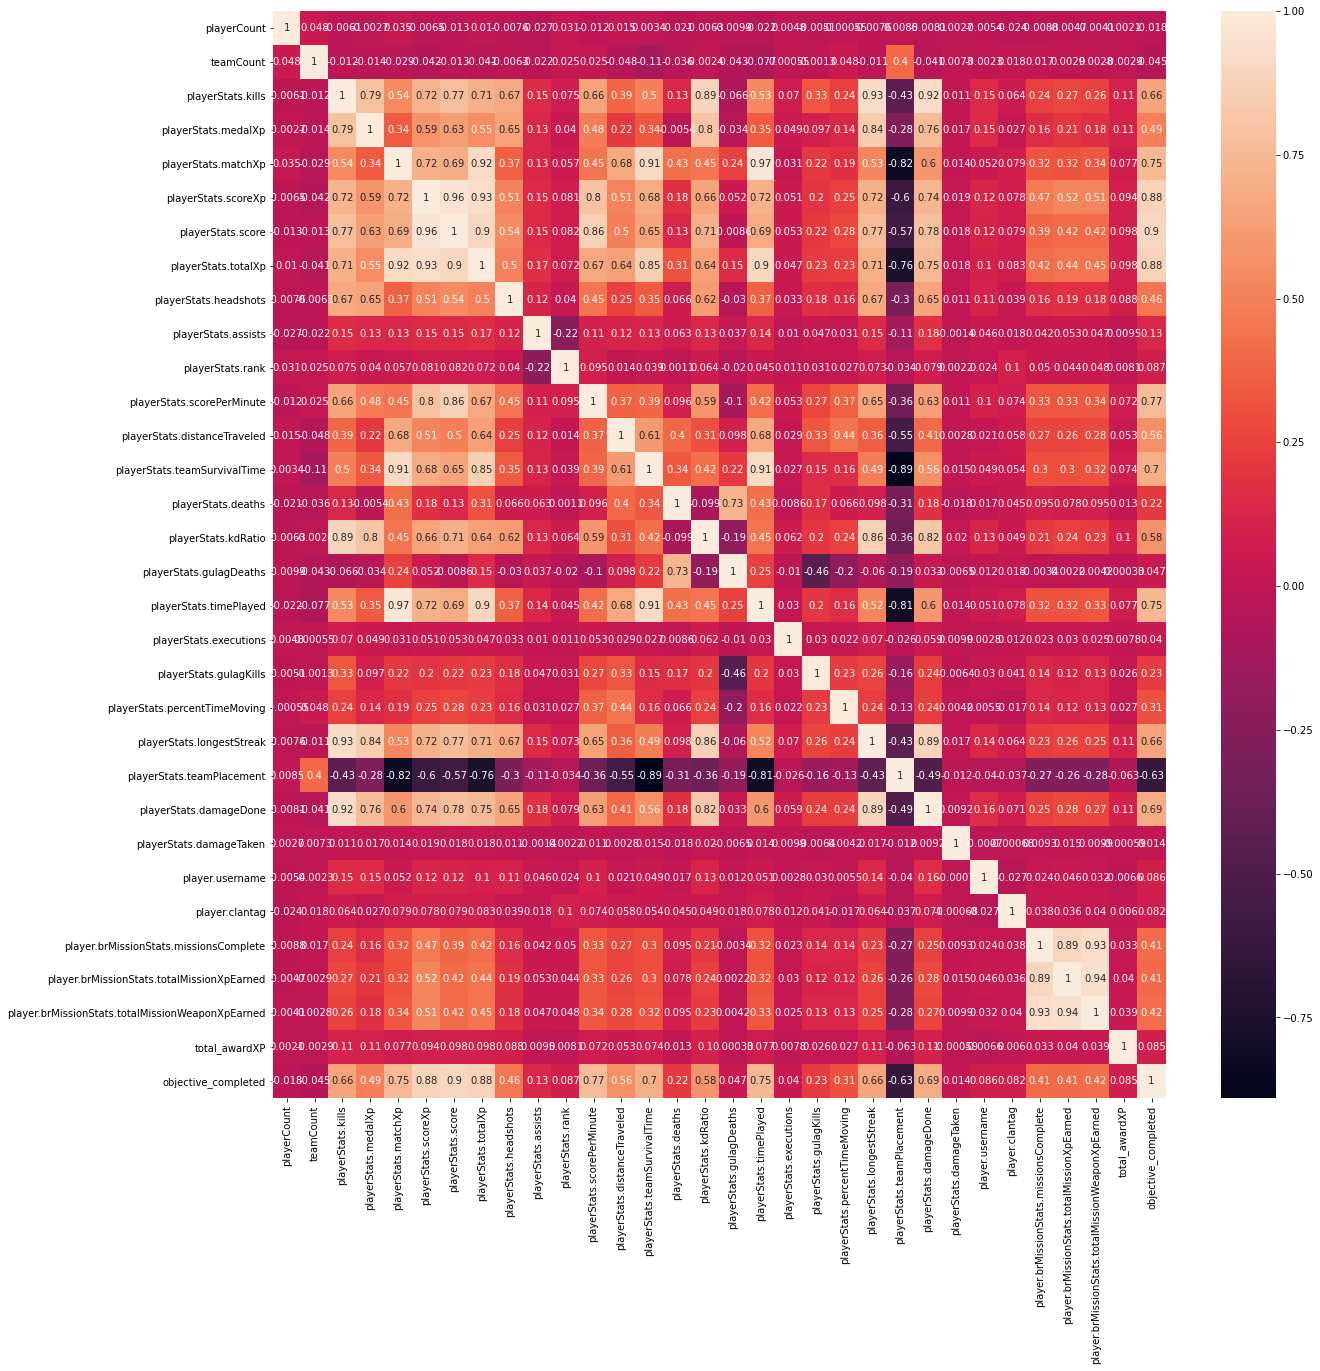

In [129]:
plt.figure(figsize=(20, 20))
sns.heatmap(df2.corr(), annot=True)
plt.show()

In [168]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [251]:
multico = df2.copy()

In [253]:
multico.drop(columns = ['mode', 'map','primary','secondary','lethal','tactical','attachment_1','attachment_2',
                         'attachment_3','sec_attachment_1','sec_attachment_2','perk_1','player.username',
                        'player.clantag'                         
                        ], inplace = True)

In [254]:
X = multico

In [255]:
X['intercept'] = 1
# Compute VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

variables         VIF
0                                        playerCount    1.090997
1                                          teamCount    2.506997
2                                  playerStats.kills   15.666372
3                                playerStats.medalXp    5.284917
4                                playerStats.matchXp   77.384102
5                                playerStats.scoreXp   59.956536
6                                  playerStats.score   32.680305
7                                playerStats.totalXp  170.705275
8                              playerStats.headshots    1.981645
9                                playerStats.assists    1.137460
10                                  playerStats.rank    1.079439
11                        playerStats.scorePerMinute    7.114519
12                      playerStats.distanceTraveled    2.590280
13                      playerStats.teamSurvivalTime   14.173293
14                                playerStats.deaths    8.802958
15                               playerStats.kdRatio    7.188937
16                           playerStats.gulagDeaths   10.338472
17                            playerStats.timePlayed   29.946792
18                            playerStats.executions    1.007154
19                            playerStats.gulagKills    4.800532
20                     playerStats.percentTimeMoving    1.669353
21                         playerStats.longestStreak   10.401948
22                         playerStats.teamPlacement   11.539859
23                            playerStats.damageDone    8.533242
24                           playerStats.damageTaken    1.001981
25            player.brMissionStats.missionsComplete    7.686534
26        player.brMissionStats.totalMissionXpEarned   10.192781
27  player.brMissionStats.totalMissionWeaponXpEarned   13.916910
28                                     total_awardXP    1.015457
29                               objective_completed    6.876567
30                                         intercept  396.077267

Looking at the correlation matrix Team Placement with its negative defining axis immediately stands out supporting the fact it is a sensible dependent variable for this analysis. 

Certain variables clearly need to be removed due to their strong correlation with Team Placement and the mulitcollinearity they share with other variables:
       
        playerStats.teamSurvivalTime, 
        playerStats.timePlayed,
        playerStats.matchXp,
        playerStats.totalXp,
        playerStats.scoreXp,
        playerStats.score,
        playerStats.distanceTraveled,
        playerStats.damageTaken,
        playerStats.damageDone,
        objective_completed
        
Put simply, the higher the score or the time played of a player the better his Team Placement. Thus, keeping these obvious variables within the dataset is not very helpful when trying to answer the bigger question. In addition, becasue the dataset is peppered with multicollinearity (i.e. the bigger the stat the longer a player has played and thus the better his final ranking, some new variables were engineered in an attempt to eliminate the presence of time played on each variable:
   
    Distance travelled per minute played
    Damage done per minute played
    Damage taken per minuted played
    objective_completed per minute played
    weaponxp per minute played
    missionxp per minute played
    missions completed per minute played
    


    
N.B. playerStats.ranks, playerCount, playerStats.damageTaken and duration will be further examined as their respetively week correlations standout as odd
    


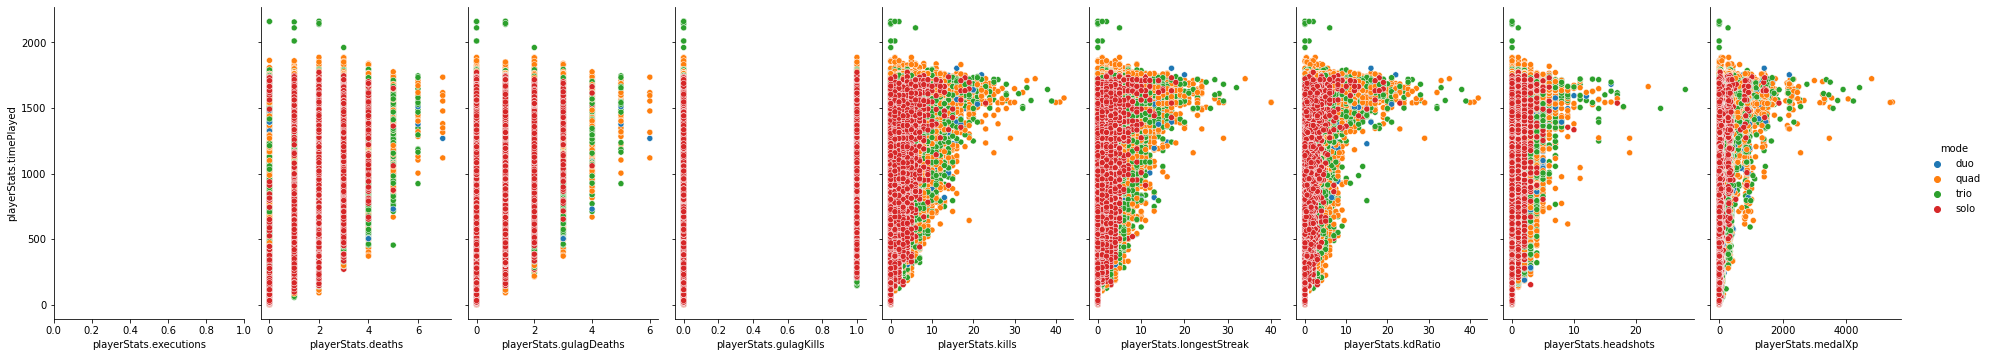

In [257]:
# investigating the relationship with time played
pp = sns.pairplot(data= df2,
                  y_vars=['playerStats.timePlayed'],
                  x_vars= ['playerStats.executions','playerStats.deaths','playerStats.gulagDeaths','playerStats.gulagKills',
                           'playerStats.kills',
                           'playerStats.longestStreak',
                           'playerStats.kdRatio','playerStats.headshots','playerStats.medalXp'], hue = 'mode', height = 5, aspect = 0.6)

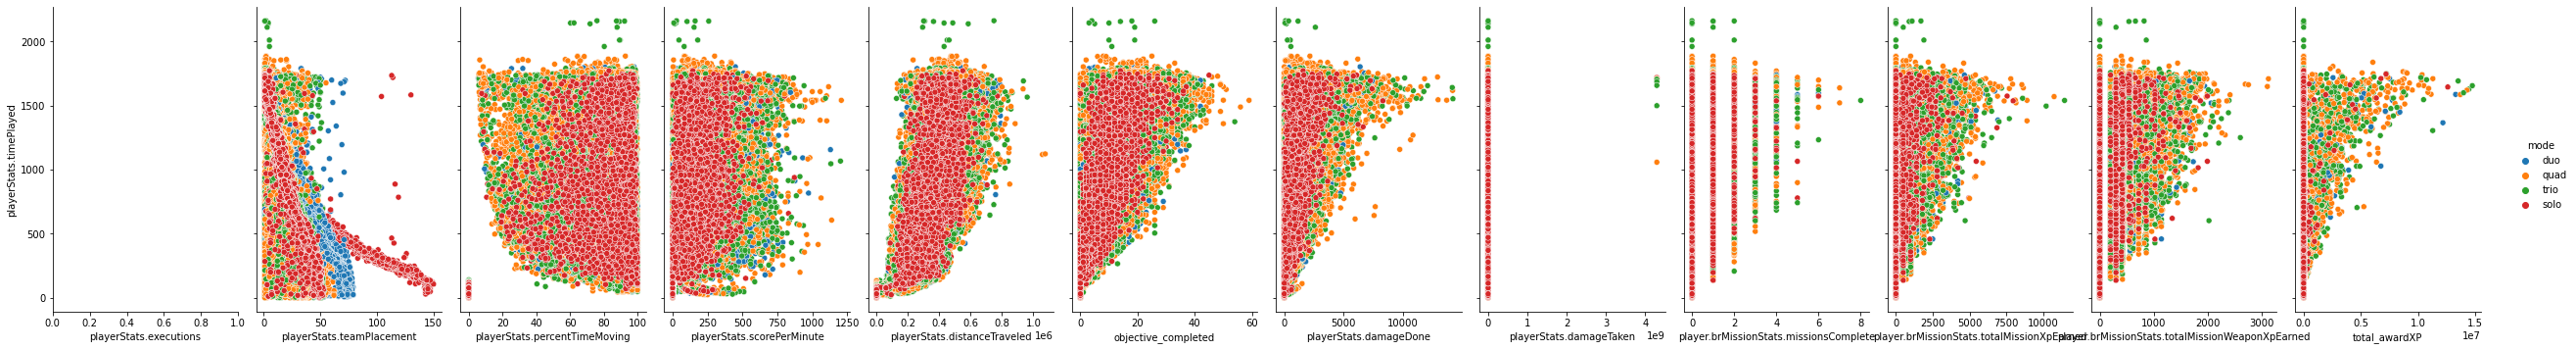

In [258]:
# investigating the relationship with time played
pp = sns.pairplot(data=df2,
                  y_vars=['playerStats.timePlayed'],
                  x_vars= ['playerStats.executions','playerStats.teamPlacement',
                           'playerStats.percentTimeMoving','playerStats.scorePerMinute',
                           'playerStats.distanceTraveled','objective_completed','playerStats.damageDone',
                   'playerStats.damageTaken','player.brMissionStats.missionsComplete','player.brMissionStats.totalMissionXpEarned'
                          ,'player.brMissionStats.totalMissionWeaponXpEarned', 'total_awardXP'], hue = 'mode', height = 5, aspect = 0.6)

In [259]:
# featuring new variables for varibales, which originally are too linked to time time played
df2['playerStats.timePlayed'] = df2['playerStats.timePlayed']/60
df2['dtpermin'] = df2['playerStats.distanceTraveled'] / df2['playerStats.timePlayed']
df2['takenpermin'] = df2['playerStats.damageTaken'] / df2['playerStats.timePlayed']
df2['donepermin'] = df2['playerStats.damageDone'] / df2['playerStats.timePlayed']
df2['objecpermin'] = df2['objective_completed'] / df2['playerStats.timePlayed']
df2['missionspermin'] = df2['player.brMissionStats.missionsComplete'] / df2['playerStats.timePlayed']
df2['missionxppermin'] = df2['player.brMissionStats.totalMissionXpEarned'] / df2['playerStats.timePlayed']
df2['weaponxppermin'] = df2['player.brMissionStats.totalMissionWeaponXpEarned'] / df2['playerStats.timePlayed']
df2['awardxppermin'] = df2['total_awardXP'] / df2['playerStats.timePlayed']
df2['medalxppermin'] = df2['playerStats.medalXp'] / df2['playerStats.timePlayed']

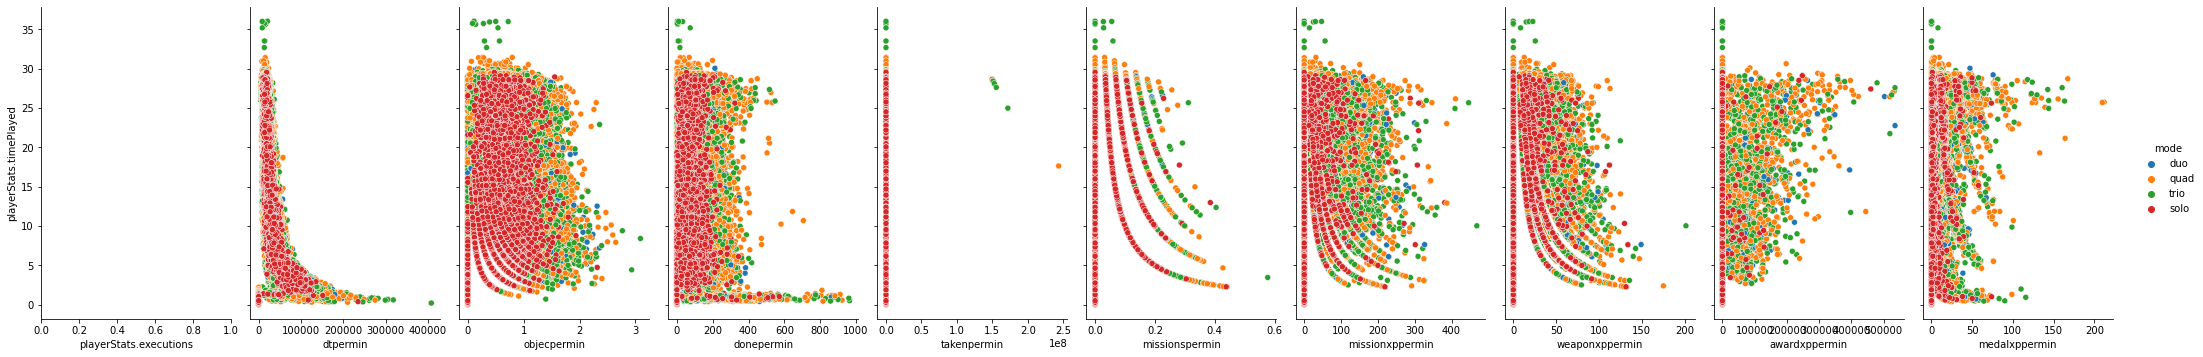

In [260]:
# investigating the relationship with time played o fnew variables
pp = sns.pairplot(data=df2,
                  y_vars=['playerStats.timePlayed'],
                  x_vars= ['playerStats.executions','dtpermin',
                           'objecpermin', 'donepermin','takenpermin','missionspermin',
                          'missionxppermin', 'weaponxppermin','awardxppermin','medalxppermin'], hue = 'mode', height = 5, aspect = 0.6)

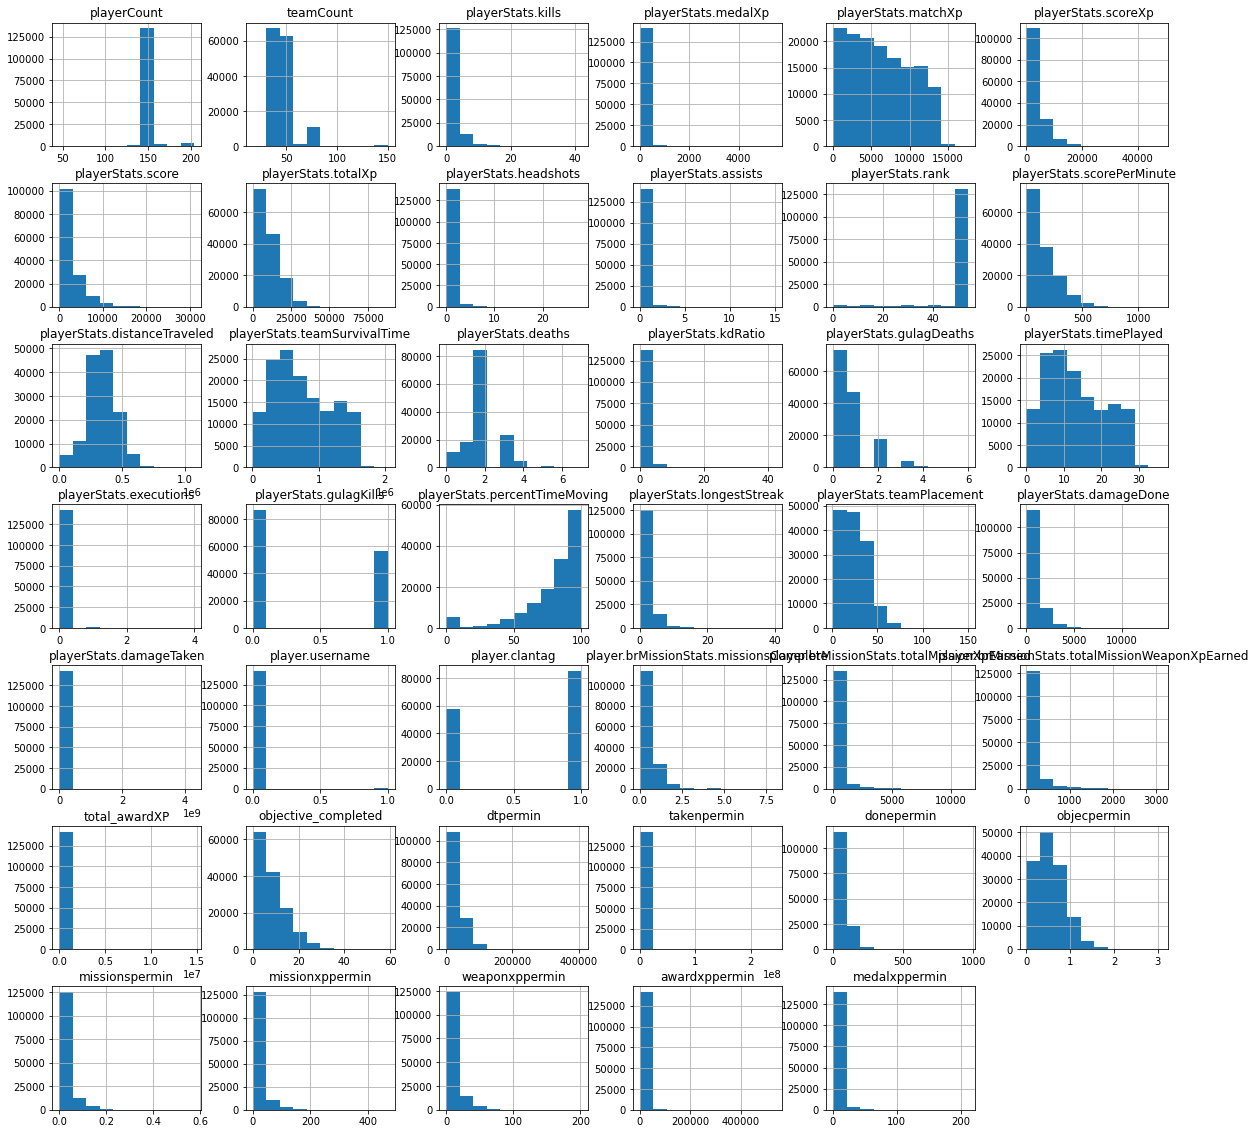

In [261]:
pd.DataFrame(df2).hist(figsize=(20,20), sharex=False, sharey=False)
plt.show()

From the first two plots we can clearly see that there is a positive relationship between time played and 
the size of the variable i.e. deaths, kills, kdratio, etc, which highlights a multicillinearity issue amongst the dataset. 

However, we can notice that this relationship disappears once the new variables have been engineered. Some plots look very similiar (i.e. missions per in, objective per min, mission xp per min and weapon xp per min) but this is because these variables (as illustrated below) share multicollinearity amongst them.

Other intersting features from these plots and the histograms are:
 
 1) Clear outliers  amongst many variables (notably: damage taken per min, which should explain its weak correlation with team placement)

2) There are a few 0 values for percentage time travelled and distance travelled, which shall require investigating

3) There is a distinct speration of the data between the game modes, which could suggest doing a game mode analyisis

4) The team placement histogram is skewed to the left


In [262]:
# These variables are removed because they simply giveaway the answer. I.e logically, the teams with the longest 
# survival time or with the hishest scores and xp are likely to have the best placement
# total awardxp and executions are removed due to the lack of data
# Player rank and count columns will be removed as the data is heavily focused around the 50 and 150 marks 
# It is assumed that it is easier to win with less players / higher ranked players are more likely to be successful
df2.drop(columns = ['playerStats.teamSurvivalTime', 'playerStats.timePlayed','playerStats.matchXp',
                    'playerStats.totalXp', 'playerStats.scoreXp', 'playerStats.score','playerStats.damageDone',
                   'playerStats.damageTaken','playerStats.distanceTraveled', 'objective_completed','playerStats.medalXp',
                   'player.brMissionStats.missionsComplete',
                    'player.brMissionStats.totalMissionXpEarned',
                    'player.brMissionStats.totalMissionWeaponXpEarned','total_awardXP','awardxppermin','playerStats.rank', 
                    'playerCount','playerStats.executions' ], inplace = True)


### EDA of player stats

In [263]:
# Selecting the relvant player stat columns
playerstats1 = df2.iloc[:, 3:16]

In [264]:
playerstats2 = df2.iloc[:, 26:]

In [265]:
playerstats = pd.concat([playerstats1,playerstats2], axis = 1)

In [266]:
# removing the binary columns
playerstats.drop(columns = ['playerStats.assists','playerStats.gulagDeaths',
                           'playerStats.headshots','playerStats.deaths', 'playerStats.gulagKills', 'playerStats.longestStreak'
                           ,'player.username', 'player.clantag'
                           ], inplace = True)


In [267]:
scaler = StandardScaler()
playerstats_stand = pd.DataFrame(scaler.fit_transform(playerstats), columns=playerstats.columns)

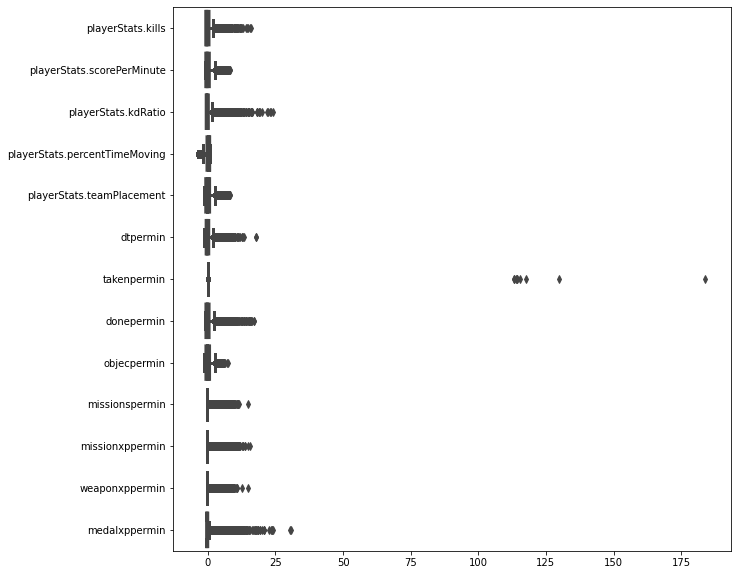

In [268]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(data=playerstats_stand, orient='h', fliersize=5,
            linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

This box plot further emphasises that the data is peppered with outliers

In [269]:
# as observed damageTaken has a strong outlier which should be removed from main df2
df2.drop(df2[df2['takenpermin'] > 200].index, inplace = True)
df2.drop(df2[df2['medalxppermin'] > 10].index, inplace = True)
df2.drop(df2[df2['playerStats.kdRatio'] > 10].index, inplace = True)
df2.drop(df2[df2['missionxppermin'] > 160].index, inplace = True)

In [270]:
playerstats.drop(playerstats[playerstats['takenpermin'] > 200].index, inplace = True)
playerstats.drop(playerstats[playerstats['medalxppermin'] > 10].index, inplace = True)
playerstats.drop(playerstats[playerstats['playerStats.kdRatio'] > 10].index, inplace = True)
playerstats.drop(playerstats[playerstats['missionxppermin'] > 160].index, inplace = True)

In [271]:
df2.sort_values(by = 'dtpermin', ascending = True)[:50] 

mode      map  teamCount  playerStats.kills  playerStats.headshots  \
94992   trio  mp_don3         51                0.0                    0.0   
3544    trio  mp_don3         52                0.0                    0.0   
105822  trio  mp_don3         51                0.0                    0.0   
51320    duo  mp_don3         78                0.0                    0.0   
51314    duo  mp_don3         78                0.0                    0.0   
105810  trio  mp_don3         51                0.0                    0.0   
105805  trio  mp_don3         51                0.0                    0.0   
30116   trio  mp_don3         50                0.0                    0.0   
105802  trio  mp_don3         51                0.0                    0.0   
105793  trio  mp_don3         51                0.0                    0.0   
105787  trio  mp_don3         51                0.0                    0.0   
30143   trio  mp_don3         50                0.0                    0.0   
51257    duo  mp_don3         78                0.0                    0.0   
3562    trio  mp_don3         52                0.0                    0.0   
105770  trio  mp_don3         51                0.0                    0.0   
30070   trio  mp_don3         51                0.0                    0.0   
105765  trio  mp_don3         51                0.0                    0.0   
30156   trio  mp_don3         50                0.0                    0.0   
30180   trio  mp_don3         50                0.0                    0.0   
30187   trio  mp_don3         50                0.0                    0.0   
82940   trio  mp_don3         51                0.0                    0.0   
30197   trio  mp_don3         50                0.0                    0.0   
51214   trio  mp_don3         51                0.0                    0.0   
51213   trio  mp_don3         51                0.0                    0.0   
30295   trio  mp_don3         51                0.0                    0.0   
30315   trio  mp_don3         51                0.0                    0.0   
30335   trio  mp_don3         51                0.0                    0.0   
30365   trio  mp_don3         51                0.0                    0.0   
82993   trio  mp_don3         51                0.0                    0.0   
137951  quad  mp_don3         40                0.0                    0.0   
51192   trio  mp_don3         51                0.0                    0.0   
30154   trio  mp_don3         50                0.0                    0.0   
30374   trio  mp_don3         51                0.0                    0.0   
9018     duo  mp_don3         76                0.0                    0.0   
51367    duo  mp_don3         78                0.0                    0.0   
29646    duo  mp_don3         78                0.0                    0.0   
82330   trio  mp_don3         51                0.0                    0.0   
131673  quad  mp_don3         40                0.0                    0.0   
9100    trio  mp_don3         54                0.0                    0.0   
138052  quad  mp_don3         40                0.0                    0.0   
51580   quad  mp_don3         38                0.0                    0.0   
106218  quad  mp_don3         38                0.0                    0.0   
9094    trio  mp_don3         54                0.0                    0.0   
82575   trio  mp_don3         50                0.0                    0.0   
82581   trio  mp_don3         50                0.0                    0.0   
131689  quad  mp_don3         40                0.0                    0.0   
82601   trio  mp_don3         50                0.0                    0.0   
82611   trio  mp_don3         50                0.0                    0.0   
3505    trio  mp_don3         52                0.0                    0.0   
29979   trio  mp_don3         51                0.0                    0.0   

        playerStats.assists  

In [272]:
# after further analysis all the rows where distance travelled/percentage time moving is 0 
# all the other scores are also 0
# the rows are therefore removed
df2.drop(df2[df2['dtpermin'] == 0].index, inplace = True)
playerstats.drop(playerstats[playerstats['dtpermin'] == 0].index, inplace = True)
df2.drop(df2[df2['playerStats.percentTimeMoving'] == 0].index, inplace = True)
playerstats.drop(playerstats[playerstats['playerStats.percentTimeMoving'] == 0].index, inplace = True)

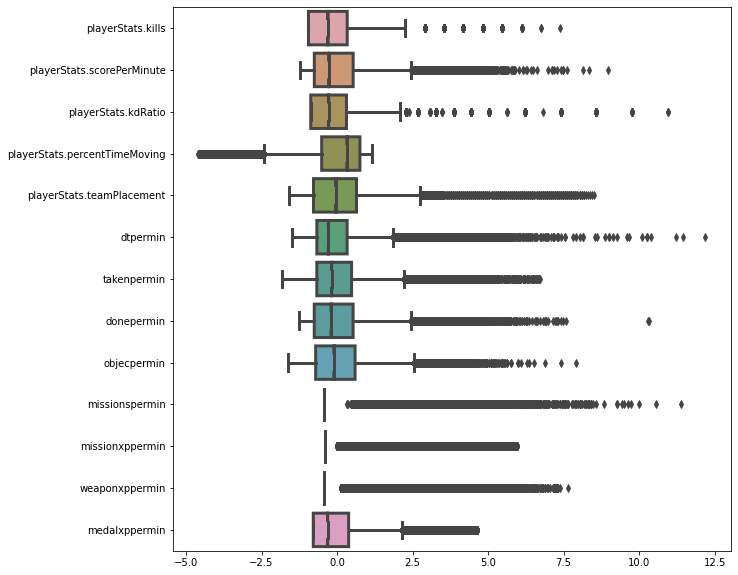

In [273]:
# Updated box plot
playerstats_stand = pd.DataFrame(scaler.fit_transform(playerstats), columns=playerstats.columns)
fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(data=playerstats_stand, orient='h', fliersize=5,
            linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

In [274]:
df2.shape

(123643, 34)

We can see that variables follow a similar distribution excluding the outliers that have not been accounted for and weaponxp per min and mission xp per min

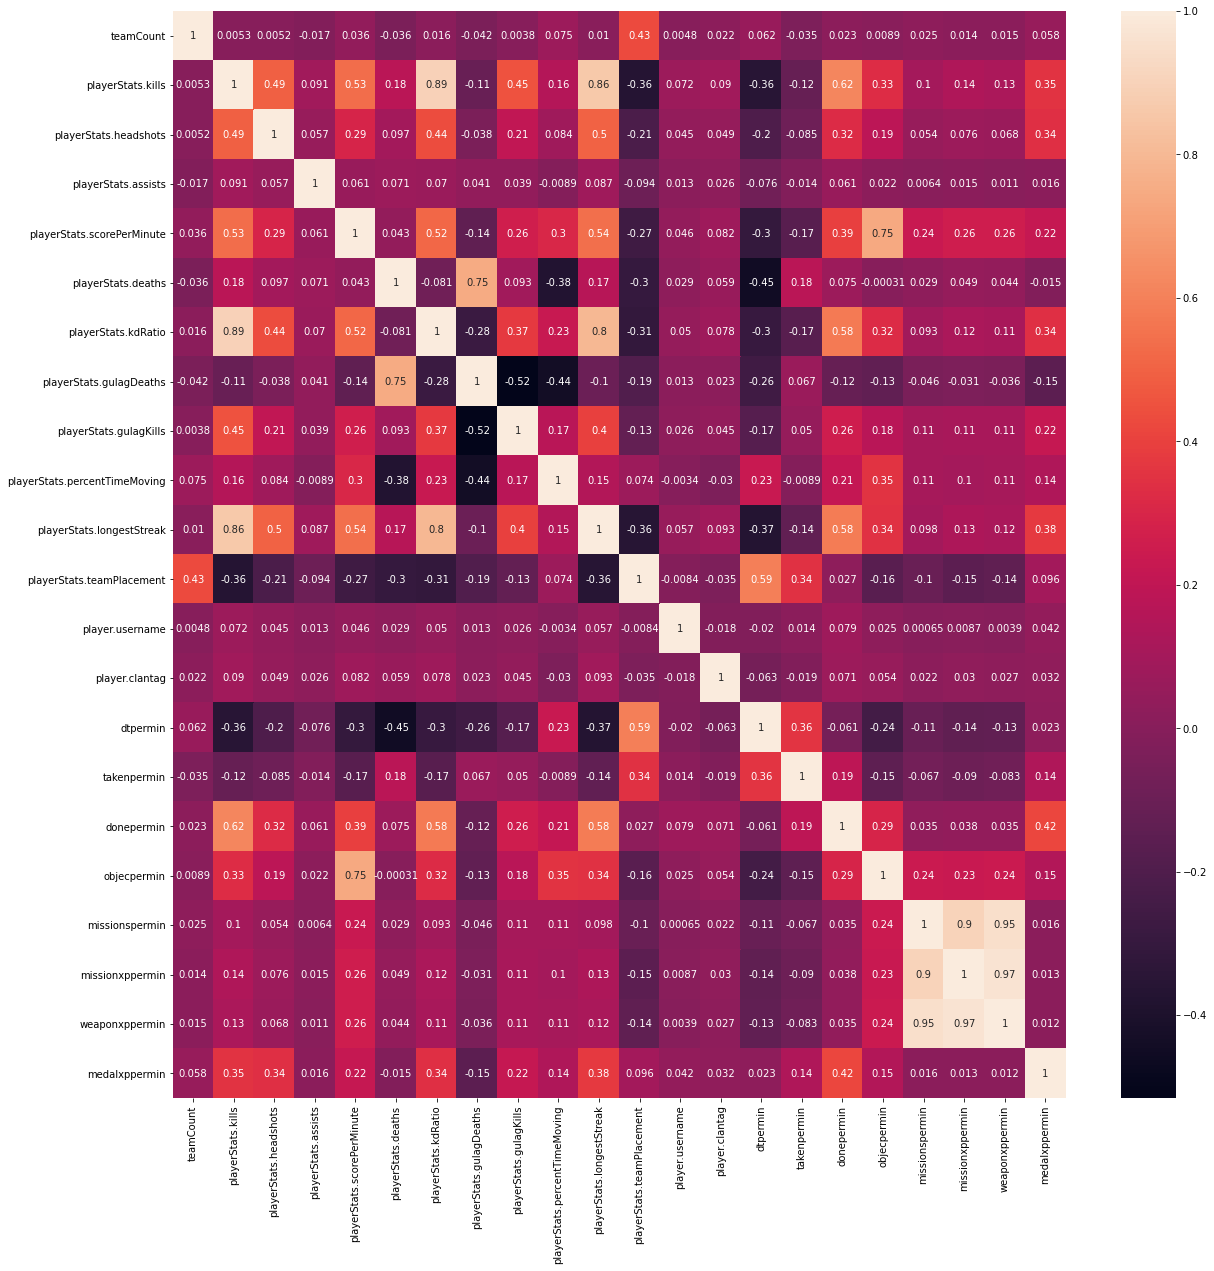

In [275]:
# updated correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(df2.corr(), annot=True)
plt.show()

From the updated heat map we can see that the feature engineerng has had a significant impact in changing the relationship amingst the variables to reduce a lot of the previously observed multicollinearity (excluding the misison/missionxp/weaponxp per minute trio)

The trio and other variables such as kill are kept in the dataset as regularization will account for them during the modelling

## Relationship with team placement

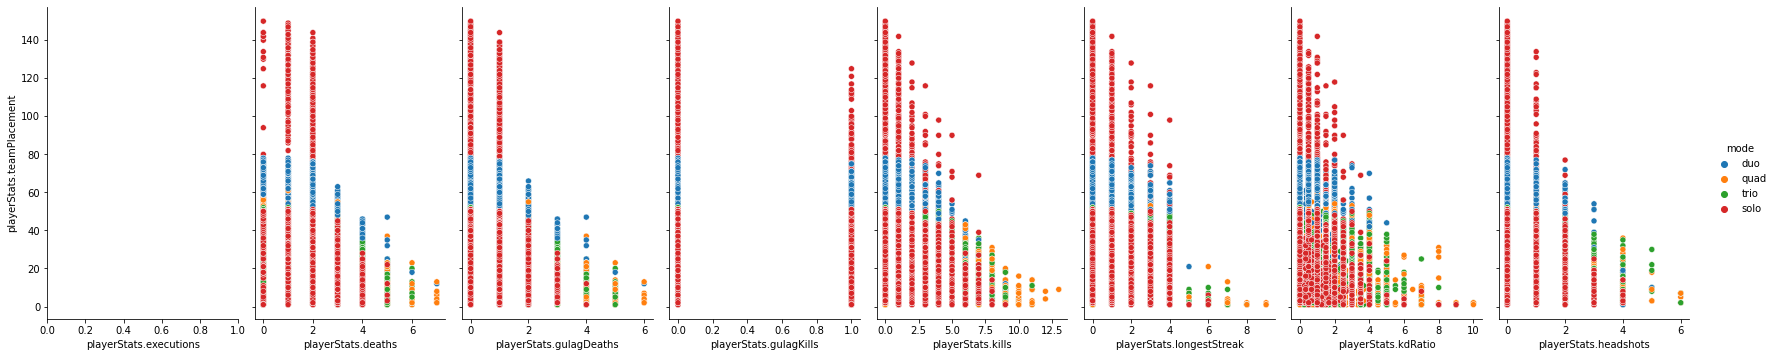

In [276]:
pp = sns.pairplot(data=df2,
                  y_vars=['playerStats.teamPlacement'],
                  x_vars= ['playerStats.executions','playerStats.deaths','playerStats.gulagDeaths','playerStats.gulagKills',
                           'playerStats.kills',
                           'playerStats.longestStreak',
                           'playerStats.kdRatio','playerStats.headshots'], hue = 'mode', height = 5, aspect = 0.6)


Deaths is an odd variable for a) its positive relationship and b) the amounts some players experienced. After further research it turns out richer teams (i.e the more successful ones) can buy back their players

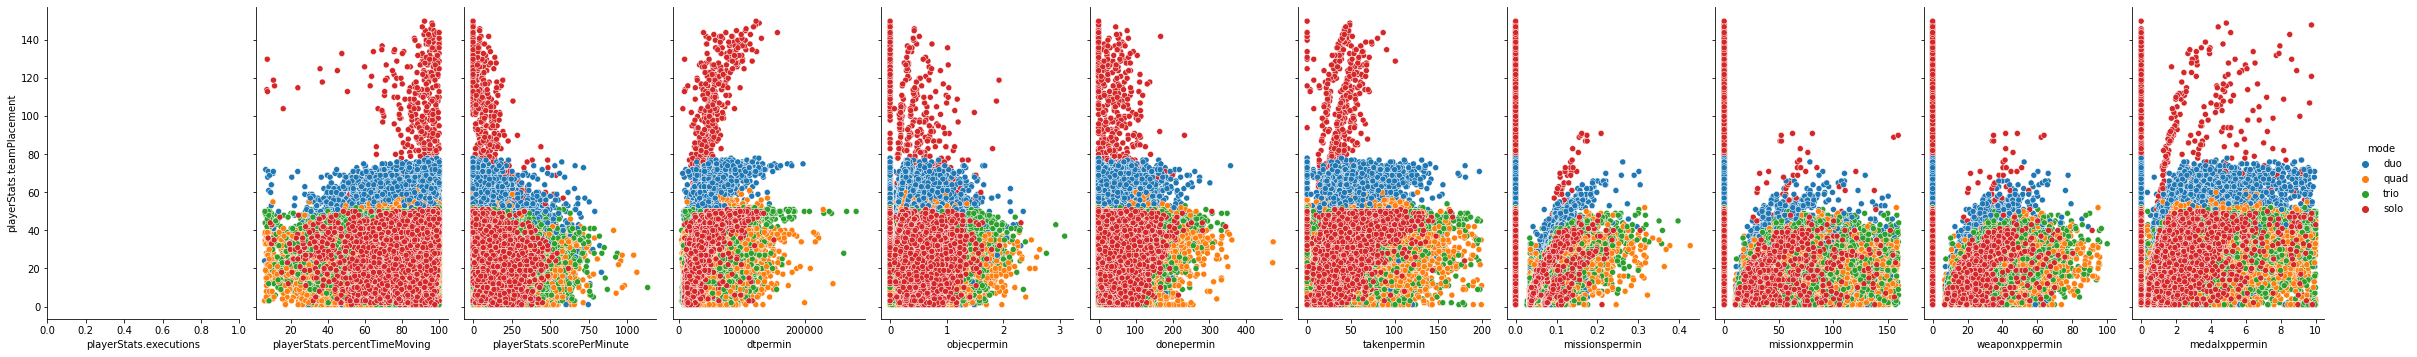

In [277]:
pp = sns.pairplot(data=df2,
                  y_vars=['playerStats.teamPlacement'],
                  x_vars= ['playerStats.executions','playerStats.percentTimeMoving','playerStats.scorePerMinute',
                           'dtpermin',
                           'objecpermin', 'donepermin','takenpermin','missionspermin',
                          'missionxppermin', 'weaponxppermin','medalxppermin'], hue = 'mode', height = 5, aspect = 0.6)
                

From these plots we can spot that:

1) There is an obvious disitinction between the game modes, which further indicates the importance of doing individual analysis

2) Logically teams achieve higher stats than solo players

3) Some players have opted to carry out 0 missions or objectives

## Visualisation

In [278]:
df2['primary'].value_counts()

iw8_lm_lima86        62510
iw8_sh_t9pump        41470
iw8_sn_t9standard     7131
none                  6559
iw8_ar_mike4          2442
iw8_ar_akilo47        1601
iw8_sm_t9heavy        1118
iw8_sn_kilo98          736
iw8_ar_kilo433          56
iw8_lm_kilo121          20
Name: primary, dtype: int64

In [279]:
# Dropping all the rows where there are no primary weapons becasue they are not useful for the analysis
df2.drop(df2[df2['primary'] == 'none'].index, inplace = True)

In [280]:
# dummifying 
df_dummy = pd.get_dummies(df2.copy(), columns = [
 'map','mode',
 'primary',
 'secondary',
 'lethal',
 'tactical',
 'attachment_1',
 'attachment_2',
 'attachment_3',
 'sec_attachment_1',                                      
 'sec_attachment_2',
 'perk_1'], drop_first = True)

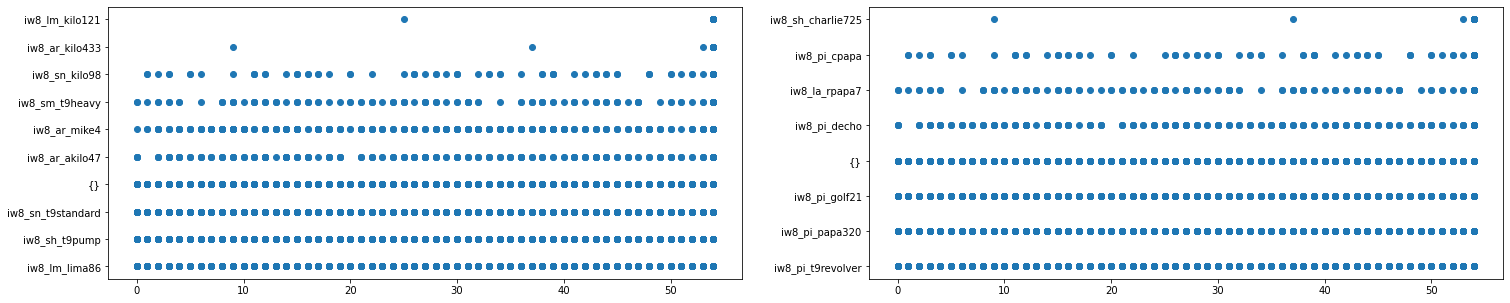

In [281]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25, 5), sharex=True)
ax[0].scatter(df['playerStats.rank'], df['primary'])
ax[1].scatter(df['playerStats.rank'], df['secondary'])

This plot illustrates that there is no obvious relationship between rank and weapon

In [285]:
df_dummy

teamCount  playerStats.kills  playerStats.headshots  \
0              78                2.0                    0.0   
1              78                3.0                    1.0   
2              78                3.0                    0.0   
3              78                2.0                    1.0   
4              78                1.0                    0.0   
...           ...                ...                    ...   
142601         51                1.0                    0.0   
142602         51                6.0                    2.0   
142603         51                2.0                    1.0   
142604         51                4.0                    1.0   
142605         51                4.0                    1.0   

        playerStats.assists  playerStats.scorePerMinute  playerStats.deaths  \
0                       0.0                  122.411693                 2.0   
1                       0.0                  386.473430                 2.0   
2                       0.0                  195.725534                 2.0   
3                       0.0                  103.187919                 2.0   
4                       0.0                   90.909091                 2.0   
...                     ...                         ...                 ...   
142601                  0.0                  293.193717                 1.0   
142602                  0.0                  315.182575                 1.0   
142603                  0.0                  128.072445                 4.0   
142604                  0.0                  147.580645                 2.0   
142605                  0.0                  271.594684                 2.0   

        playerStats.kdRatio  playerStats.gulagDeaths  playerStats.gulagKills  \
0                       1.0                      1.0                     0.0   
1                       1.5                      0.0                     1.0   
2                       1.5                      0.0                     1.0   
3                       1.0                      1.0                     0.0   
4                       0.5                      0.0                     1.0   
...                     ...                      ...                     ...   
142601                  1.0                      0.0                     0.0   
142602                  6.0                      0.0                     1.0   
142603                  0.5                      3.0                     0.0   
142604                  2.0                      0.0                     1.0   
142605                  2.0                      0.0                     1.0   

        playerStats.percentTimeMoving  playerStats.longestStreak  \
0                           90.787710                        2.0   
1                           93.264244                        2.0   
2                           77.015650                        2.0   
3                           91.522156                        2.0   
4                           93.750000                        1.0   
...                               ...                        ...   
142601                      95.528450                        1.0   
142602                      97.645430                        4.0   
142603                      83.102490                        2.0   
142604                      91.247670                        3.0   
142605                      92.576030                        3.0   

        playerStats.teamPlacement  player.username  player.clantag  \
0                            23.0                0               1   
1                            34.0                0               1   
2                            30.0                0               1   
3                            38.0                0               0   
4                            62.0                0               1   
...                           ...              ...             ...   
142601                       32.0 

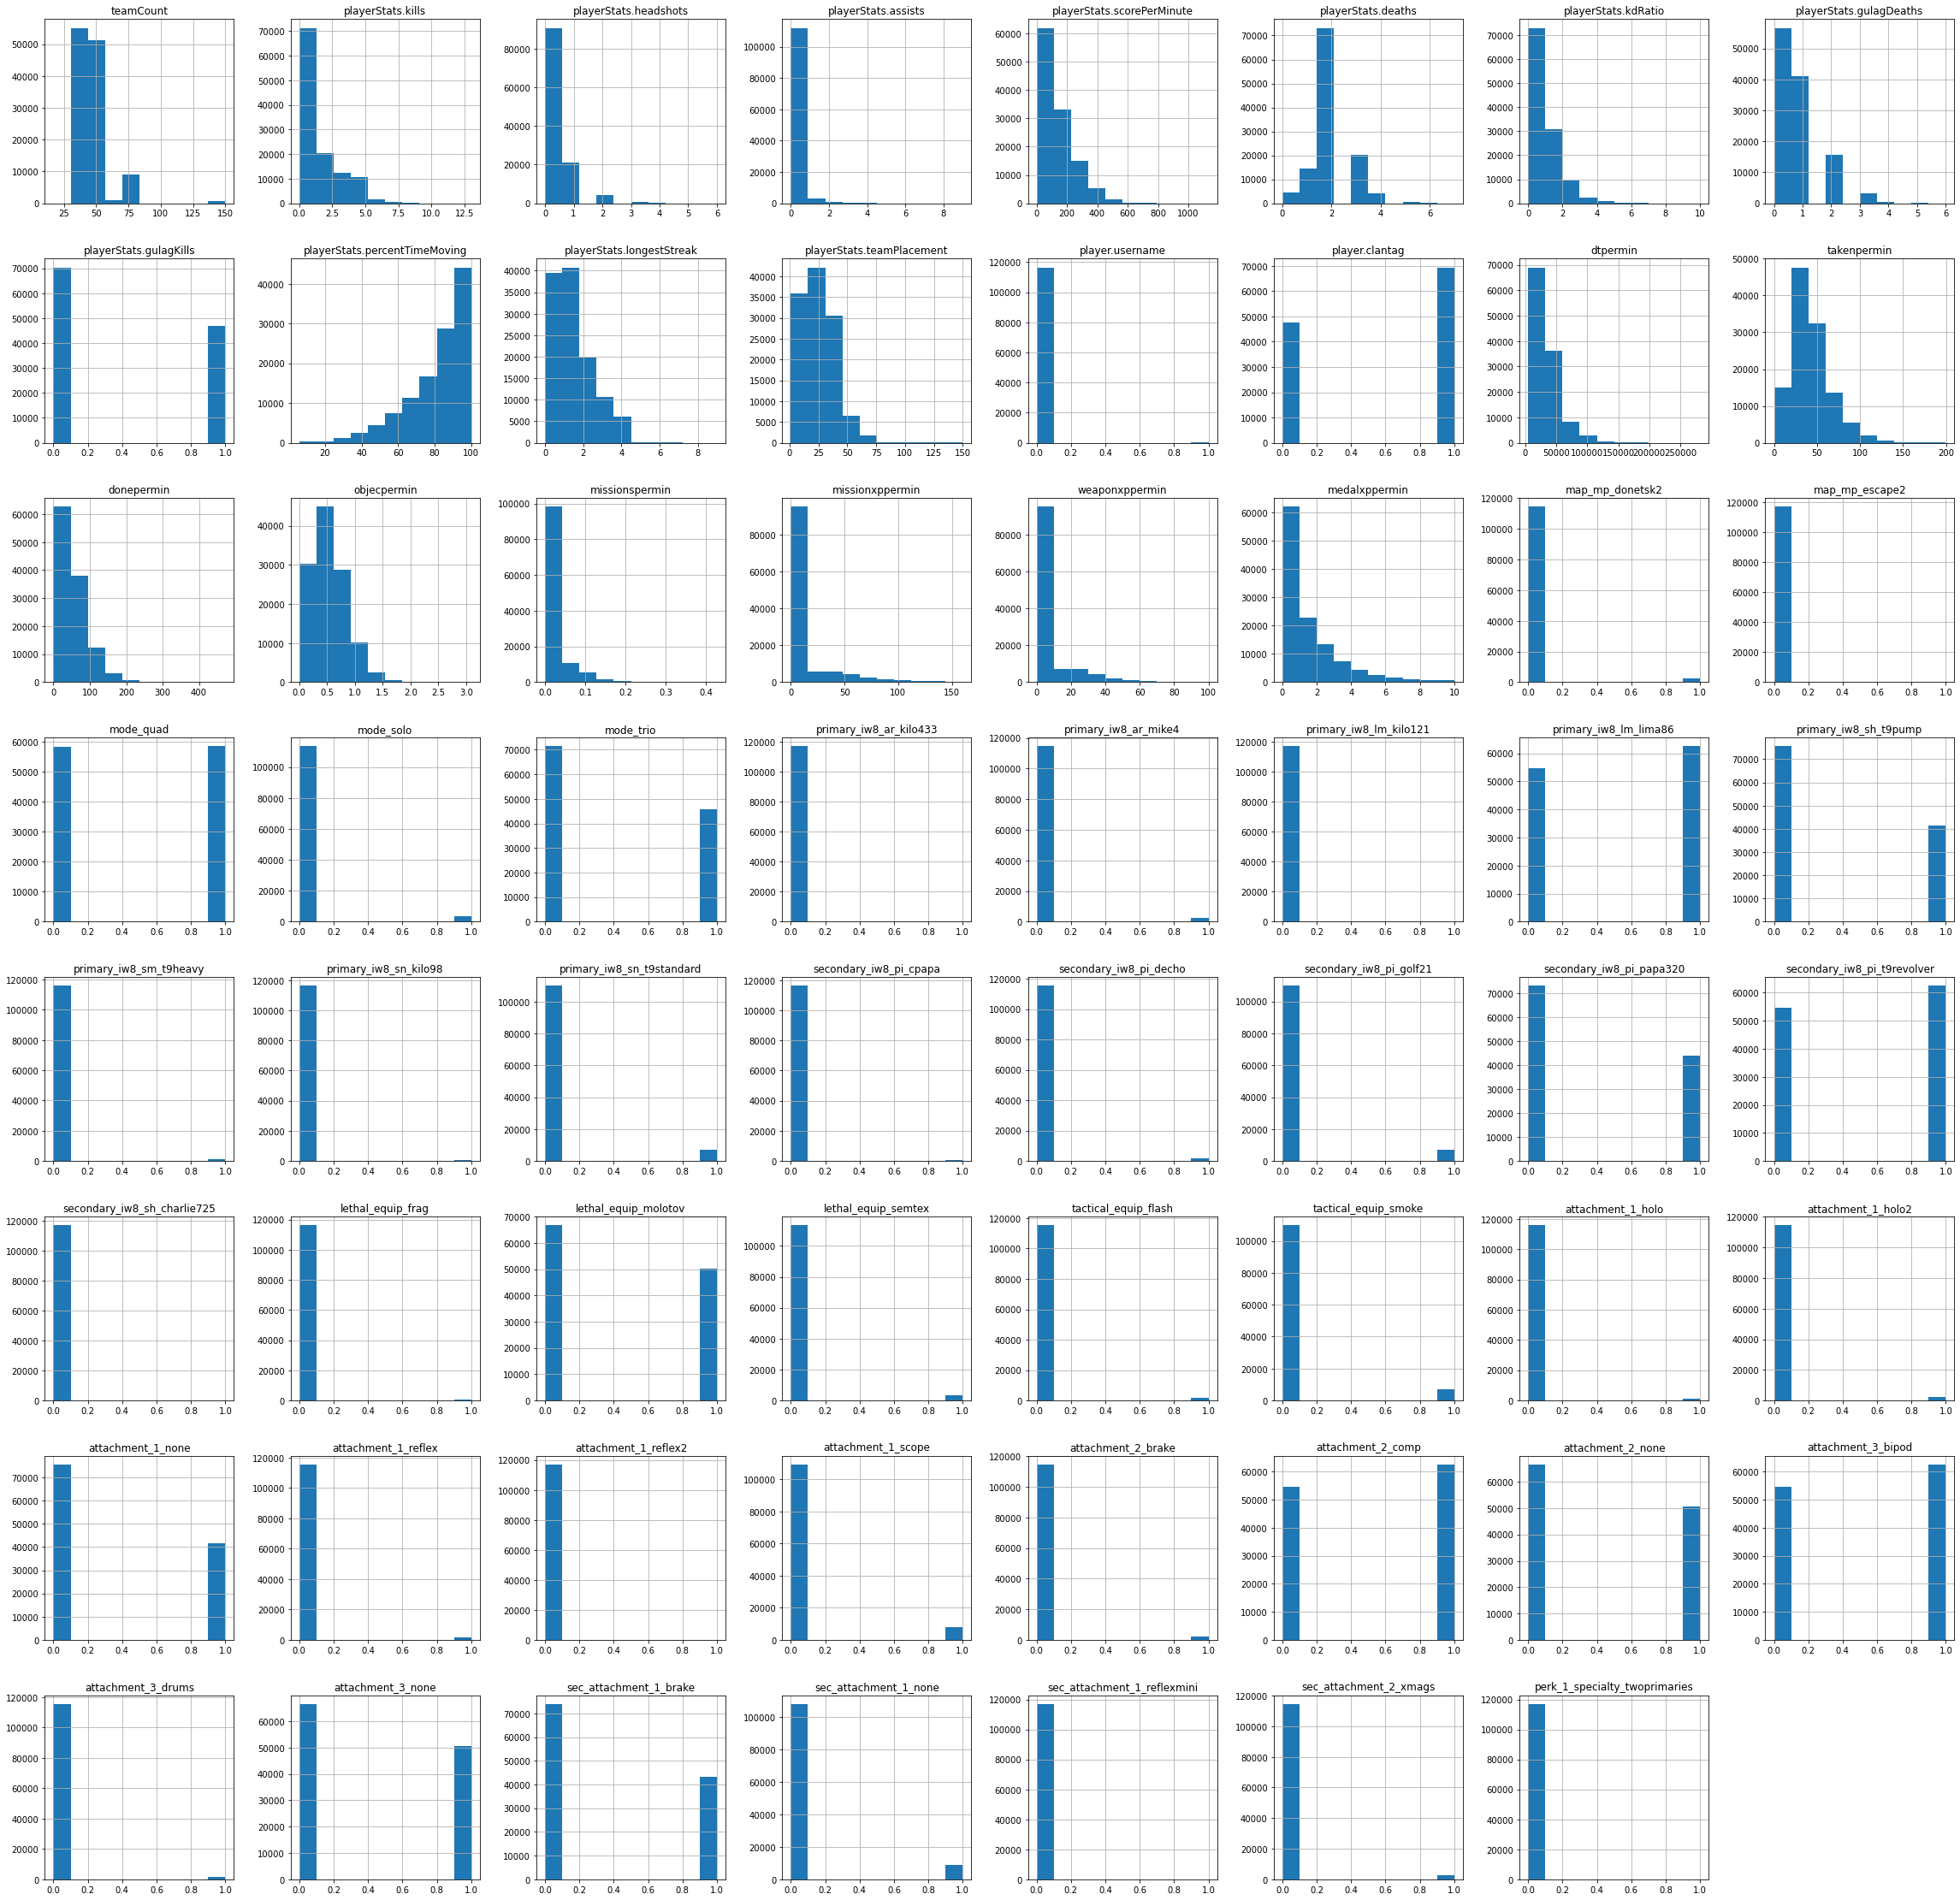

In [284]:
pd.DataFrame(df_dummy).hist(figsize=(40,40), sharex=False, sharey=False)
plt.show()

Standout charts:

1) Very few of the games are played solo

2) The map distribution is very rigid

In [164]:
df_dummy.to_csv('official_wz_update.csv')

In [165]:
df2.to_csv('official_wz_update_mode.csv')